# 1D_CNN + Data_Augmentation (time stretch + pitch shift)

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras import optimizers
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from keras import regularizers
import matplotlib.pyplot as plt
import librosa.display

Using TensorFlow backend.


In [2]:
# import competition dataset and downsampling to 4410
x_train = np.load('train_data.npy')
#x_train = x_train[:,:4410] 

y_train = pd.read_csv('train_labels.csv')
y_train = np.array(y_train)
y_train = y_train[:,1]

x_test = np.load('test_data.npy')
#x_test = x_test[:,:4410]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


### Audio Data Augmentation 

* create synthetic training samples by adding small perturbations on initial training set. 
* in audio data augmentation can be peromed by stretch and roll, pitch shift and so on

In [3]:
# DATA_AUGMENTATION___pitch shift

array_ps = []
for i in range(len(x_train)):
    y_ps = librosa.effects.pitch_shift(x_train[i],x_train.shape[1], n_steps=3)
    array_ps.append(y_ps)
x_ps = np.vstack(array_ps)
print(x_ps.shape)


(3999, 44100)


In [4]:
# DATA_AUGMENTATION___time_stretch 
array_ts = []
for i in range(len(x_train)):
    y_ts = librosa.effects.time_stretch(x_train[i], rate=1.2)
    array_ts.append(y_ts)
x_ts = np.vstack(array_ts)
print(x_ts.shape)

(3999, 36750)


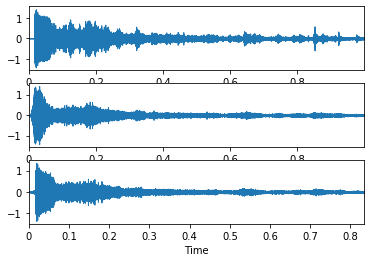

In [5]:
plt.subplot(311)
librosa.display.waveplot(x_train[0],sr=44100)
plt.subplot(312)
librosa.display.waveplot(x_ps[0],sr=44100)
plt.subplot(313)
librosa.display.waveplot(x_ts[0],sr=44100)

In [6]:
# decide if need to do the normalization process on the data augumentation datasets

print("x_ps:",np.amax(x_ps),np.amin(x_ps),x_ps.shape)
print("x_ts:",np.amax(x_ts),np.amin(x_ts),x_ts.shape)
print("x_train:",np.amax(x_train),np.amin(x_train),x_train.shape)

x_ps: 2.9234622 -2.8823664 (3999, 44100)
x_ts: 3.4674718 -2.953254 (3999, 36750)
x_train: 1.9183551 -1.940241 (3999, 44100)


In [7]:
# creat new train datasets after the data augmentation

x_train_new = np.concatenate((x_train,x_ps),axis=0)     
print("the shape of x_train",x_train_new.shape)

y_train_new = np.repeat(y_train,2)
print("the shape of y_train",y_train_new.shape)

# Normalization 
normalizer = Normalizer().fit(x_ps)
x_train_new = normalizer.transform(x_train_new)
x_test_new = normalizer.transform(x_test)


# reshape
x_train_new = x_train_new.reshape(-1,x_train_new.shape[1],1)
print("the shape of x_train after reshape:",x_train_new.shape)


the shape of x_train (7998, 44100)
the shape of y_train (7998,)
the shape of x_train after reshape: (7998, 44100, 1)


In [8]:
# make output a 2 dim vector indicating class
y_train_new = np_utils.to_categorical(y_train_new, 2)

In [9]:
# create 1-D CNN

model = Sequential()
model.add(Conv1D(32, kernel_size=5, 
                 activation='relu',
                 input_shape=(44100,1))) 
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=50,stride=10))

model.add(Conv1D(64, kernel_size=5, 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=50,stride=10))

# model.add(Conv1D(128, kernel_size=5, 
#                  activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=50,stride=10))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


W0926 14:57:26.043338  9520 deprecation_wrapper.py:119] From C:\Users\willi\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0926 14:57:26.071528  9520 deprecation_wrapper.py:119] From C:\Users\willi\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0926 14:57:26.075525  9520 deprecation_wrapper.py:119] From C:\Users\willi\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0926 14:57:26.154900  9520 deprecation_wrapper.py:119] From C:\Users\willi\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please us

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 44096, 32)         192       
_________________________________________________________________
batch_normalization_1 (Batch (None, 44096, 32)         128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4405, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4401, 64)          10304     
_________________________________________________________________
batch_normalization_2 (Batch (None, 4401, 64)          256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 436, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 27904)             0         
__________

In [11]:
# compile model

adam=optimizers.Adam(lr=.0001) 
model.compile(loss='binary_crossentropy', 
              optimizer=adam,
              metrics=['accuracy'])

W0926 14:57:26.405039  9520 deprecation_wrapper.py:119] From C:\Users\willi\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0926 14:57:26.420012  9520 deprecation_wrapper.py:119] From C:\Users\willi\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0926 14:57:26.426904  9520 deprecation.py:323] From C:\Users\willi\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
print(x_train_new.shape,y_train_new.shape)

(7998, 44100, 1) (7998, 2)


In [13]:
from keras.callbacks import EarlyStopping
EarlyStopping = EarlyStopping(monitor='val_loss',patience=5,verbose=0,mode='auto')
model.fit(x_train_new, y_train_new, batch_size=32, epochs=30, validation_split=0.1,callbacks=[EarlyStopping])

Train on 7198 samples, validate on 800 samples
Epoch 1/30
7198/7198 [==============================] - 727s 101ms/step - loss: 0.8293 - acc: 0.8405 - val_loss: 0.3408 - val_acc: 0.9150
Epoch 2/30
7198/7198 [==============================] - 789s 110ms/step - loss: 0.4762 - acc: 0.8675 - val_loss: 0.3279 - val_acc: 0.9050
Epoch 3/30
7198/7198 [==============================] - 847s 118ms/step - loss: 0.4576 - acc: 0.8708 - val_loss: 0.3152 - val_acc: 0.9150
Epoch 4/30
7198/7198 [==============================] - 811s 113ms/step - loss: 0.4400 - acc: 0.8718 - val_loss: 0.3099 - val_acc: 0.9125
Epoch 5/30
7198/7198 [==============================] - 763s 106ms/step - loss: 0.4247 - acc: 0.8727 - val_loss: 0.3003 - val_acc: 0.9137
Epoch 6/30
7198/7198 [==============================] - 649s 90ms/step - loss: 0.4184 - acc: 0.8741 - val_loss: 0.3118 - val_acc: 0.9137
Epoch 7/30
7198/7198 [==============================] - 689s 96ms/step - loss: 0.4155 - acc: 0.8743 - val_loss: 0.3064 - val_a

KeyboardInterrupt: 

In [ ]:
# make predictions
y_predict= model.predict_classes(x_test)
print(y_predict[:500])

In [ ]:
prediction = pd.DataFrame(y_predict,columns=['label']).to_csv('submission_DataAug.csv')

In [ ]:
# with normaliztaion//loss: 0.3747 - acc: 0.8744 - val_loss: 0.3074 - val_acc: 0.9137
# remove normalization // loss: 0.4069 - acc: 0.8745 - val_loss: 0.3177 - val_acc: 0.9150